In [1]:
from nlp_functions import *
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import itertools
import string
import tensorflow_hub as hub
import tensorflow as tf
from keras import backend as K
import keras.layers as layers
from keras.models import Model, load_model
from keras.layers import Layer
from keras.utils import Sequence
from keras.layers import Activation, Conv1D, Dense, Dropout, Embedding, Flatten, GlobalMaxPool1D, LSTM
from keras.layers import Input, MaxPooling1D, GlobalAveragePooling1D, multiply, concatenate, Reshape
from keras.layers import Bidirectional
from keras.optimizers import Adam
import keras.initializers as initializers
import keras.regularizers as regularizers
import keras.constraints as constraints
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.utils import shuffle
import pickle

sess = tf.Session()

Using TensorFlow backend.


In [2]:
plt.style.use('seaborn')

In [3]:
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
elmo_path = "https://tfhub.dev/google/elmo/2"

# Load data

In [4]:
# Importing our data
sentiment140 = read_sentiment_file(DATA_DIRECTORY, 'sentiment140_train.csv')

In [5]:
# Sampling 10% the data
sentiment140 = sentiment140.sample(frac=0.1, random_state=7)

In [6]:
# Separating into characteristics and labels
X = sentiment140['text']
y = sentiment140['polarity']

In [7]:
# Cleaning the texts and mapping for easy classification
X = clean_data(X)
y = y.map({0: int(0), 4: int(1)})

In [8]:
# Calculate maximum sequence length
max_seq_length = max(X.str.len())

In [9]:
# Split the data to train and test, then train and val
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=7)

# ELMO pipeline

## Elmo Tokenizer

In [10]:
from elmo_tokenizer import ELMO_tokenizer

In [11]:
tokenizer = ELMO_tokenizer(max_seq_length)

In [12]:
train_tokens = tokenizer.predict(X_train.tolist())
train_label = y_train.tolist()

val_tokens = tokenizer.predict(X_val.tolist())
val_label = y_val.tolist()

test_tokens = tokenizer.predict(X_test.tolist())
test_label = y_test.tolist()

Converting examples to tokens:   0%|          | 0/102400 [00:00<?, ?it/s]

Converting examples to tokens:   0%|          | 0/25600 [00:00<?, ?it/s]

Converting examples to tokens:   0%|          | 0/32000 [00:00<?, ?it/s]

## Elmo Model

In [13]:
from elmo_layer import ElmoLayer

Instructions for updating:
non-resource variables are not supported in the long term


In [14]:
from keras.layers import Flatten, Masking
def build_model_elmo(max_seq_length): 
    input_tokens = Input(shape=(max_seq_length,), dtype="string")
    elmo_output = ElmoLayer(trainable=True, tf_hub=elmo_path, output_representation='default')(input_tokens)
    dense = Dense(256, activation='relu')(elmo_output)
    pred = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=input_tokens, outputs=pred)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])
    model.summary()
    return model
def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [15]:
elmo_model = build_model_elmo(max_seq_length)
initialize_vars(sess)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 138)               0         
_________________________________________________________________
elmo_layer_1 (ElmoLayer)     (None, 1024)              93600852  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 93,863,509
Trainable params: 262,661
Non-trainable params: 93,600,848
_________________________________________________________________


In [16]:
from keras.utils import plot_model
plot_model(
    elmo_model,
    to_file='../figures/elmo-arc.png',
    show_shapes=True,
    rankdir='TB',
    dpi=300);

In [17]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)
history_elmo = elmo_model.fit(
    train_tokens,
    train_label,
    validation_data=(val_tokens, val_label),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping]
)

Train on 102400 samples, validate on 25600 samples
Epoch 1/20
102400/102400 [==============================] - 1964s 19ms/step - loss: 0.4908 - accuracy: 0.7593 - precision: 0.7630 - recall: 0.7494 - val_loss: 0.4724 - val_accuracy: 0.7755 - val_precision: 0.8033 - val_recall: 0.7302
Epoch 2/20
102400/102400 [==============================] - 2042s 20ms/step - loss: 0.4558 - accuracy: 0.7830 - precision: 0.7872 - recall: 0.7733 - val_loss: 0.4540 - val_accuracy: 0.7876 - val_precision: 0.8033 - val_recall: 0.7621
Epoch 3/20
102400/102400 [==============================] - 2052s 20ms/step - loss: 0.4338 - accuracy: 0.7969 - precision: 0.8012 - recall: 0.7876 - val_loss: 0.4621 - val_accuracy: 0.7820 - val_precision: 0.8201 - val_recall: 0.7228
Epoch 4/20
102400/102400 [==============================] - 2053s 20ms/step - loss: 0.4120 - accuracy: 0.8085 - precision: 0.8121 - recall: 0.8007 - val_loss: 0.4535 - val_accuracy: 0.7905 - val_precision: 0.8026 - val_recall: 0.7708
Epoch 5/20
10

In [18]:
metrics_elmo = pd.DataFrame(history_elmo.history)
metrics_elmo

,val_loss,val_accuracy,val_precision,val_recall,loss,accuracy,precision,recall
0,0.472426,0.775469,0.803263,0.730154,0.490785,0.759316,0.763015,0.749367
1,0.454004,0.787578,0.803341,0.762079,0.455783,0.783027,0.787202,0.773276
2,0.462123,0.781953,0.820122,0.722816,0.433801,0.796924,0.801209,0.787554
3,0.453518,0.790469,0.802650,0.770822,0.412029,0.808525,0.812090,0.800734
4,0.458905,0.790078,0.798124,0.777067,0.390766,0.820508,0.825140,0.811481
5,0.476264,0.784727,0.807757,0.747795,0.365042,0.835557,0.839619,0.827878
6,0.499965,0.783164,0.770694,0.806729,0.338529,0.849248,0.854649,0.840116
7,0.534264,0.775430,0.765289,0.795098,0.312041,0.863652,0.868181,0.856159
8,0.570847,0.777031,0.766090,0.798142,0.286723,0.875967,0.880244,0.869143


In [19]:
print(f'Best training loss: {metrics_elmo.sort_values(by="val_loss", ascending=True).iloc[0,4]}')
print(f'Best training accuracy: {metrics_elmo.sort_values(by="val_loss", ascending=True).iloc[0,5]}')
print(f'Best training precision: {metrics_elmo.sort_values(by="val_loss", ascending=True).iloc[0,6]}')
print(f'Best training recall: {metrics_elmo.sort_values(by="val_loss", ascending=True).iloc[0,7]}')
print('---------------------------------------------')
print(f'Best validation loss: {metrics_elmo.sort_values(by="val_loss", ascending=True).iloc[0,0]}')
print(f'Best validation accuracy: {metrics_elmo.sort_values(by="val_loss", ascending=True).iloc[0,1]}')
print(f'Best validation precision: {metrics_elmo.sort_values(by="val_loss", ascending=True).iloc[0,2]}')
print(f'Best validation recall: {metrics_elmo.sort_values(by="val_loss", ascending=True).iloc[0,3]}')

Best training loss: 0.41202884886879476
Best training accuracy: 0.8085253834724426
Best training precision: 0.812089741230011
Best training recall: 0.8007335066795349
---------------------------------------------
Best validation loss: 0.4535182438790798
Best validation accuracy: 0.7904687523841858
Best validation precision: 0.802649736404419
Best validation recall: 0.7708219289779663


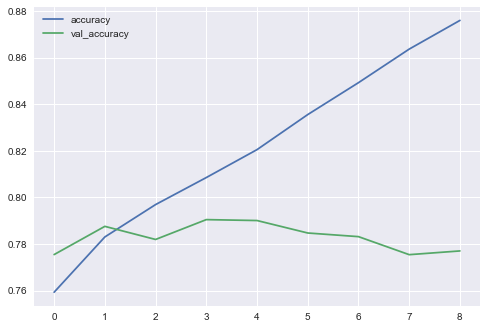

In [20]:
metrics_elmo[['accuracy','val_accuracy']].plot()
plt.savefig('../figures/elmo_acc.jpg', dpi=300)

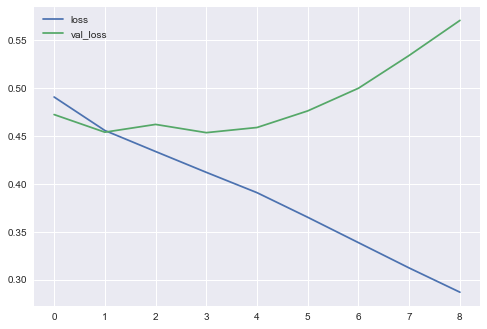

In [21]:
metrics_elmo[['loss','val_loss']].plot()
plt.savefig('../figures/elmo_loss.jpg', dpi=300)

In [23]:
# Loss metrics for the trained model
test_loss, test_accuracy, test_precision, test_recall = elmo_model.evaluate(test_tokens, test_label)

32000/32000 [==============================] - 507s 16ms/step


In [24]:
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')
print(f'Test precision: {test_precision}')
print(f'Test recall: {test_recall}')

Test loss: 0.4564696417748928
Test accuracy: 0.7904999852180481
Test precision: 0.7986603379249573
Test recall: 0.7729246616363525


In [25]:
elmo_model.save('../models/elmo_model.h5')

# BERT pipeline

## Bert tokenizer

In [26]:
# Create datasets (Only take up to max_seq_length words for memory)
train_text = X_train.tolist()
train_text = [' '.join(t.split()[0:max_seq_length]) for t in train_text]
train_text = np.array(train_text, dtype=object)[:, np.newaxis]
train_label = y_train.tolist()

val_text = X_val.tolist()
val_text = [' '.join(t.split()[0:max_seq_length]) for t in val_text]
val_text = np.array(val_text, dtype=object)[:, np.newaxis]
val_label = y_val.tolist()

test_text = X_test.tolist()
test_text = [' '.join(t.split()[0:max_seq_length]) for t in test_text]
test_text = np.array(test_text, dtype=object)[:, np.newaxis]
test_label = y_test.tolist()

In [27]:
from bert_tokenizer import BERT_tokenizer

In [28]:
tokenizer = BERT_tokenizer(bert_path, max_seq_length)

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


In [29]:
(train_input_ids, train_input_masks, train_segment_ids, train_labels) = tokenizer.predict(train_text, train_label)
(val_input_ids, val_input_masks, val_segment_ids, val_labels) = tokenizer.predict(val_text, val_label)
(test_input_ids, test_input_masks, test_segment_ids, test_labels) = tokenizer.predict(test_text, test_label)


Converting examples to features:   0%|          | 0/102400 [00:00<?, ?it/s]

INFO:tensorflow:Writing example 0 of 102400


INFO:tensorflow:Writing example 0 of 102400


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:Tokens True: [CLS] i m going to sound really old fashioned here but i still use my dad s old silver arrow kind of an antique if you may [SEP]


INFO:tensorflow:Tokens True: [CLS] i m going to sound really old fashioned here but i still use my dad s old silver arrow kind of an antique if you may [SEP]


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i m going to sound really old fashioned here but i still use my dad s old silver arrow kind of an antique if you may [SEP]


INFO:tensorflow:tokens: [CLS] i m going to sound really old fashioned here but i still use my dad s old silver arrow kind of an antique if you may [SEP]


INFO:tensorflow:input_ids: 101 1045 1049 2183 2000 2614 2428 2214 13405 2182 2021 1045 2145 2224 2026 3611 1055 2214 3165 8612 2785 1997 2019 14361 2065 2017 2089 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 1049 2183 2000 2614 2428 2214 13405 2182 2021 1045 2145 2224 2026 3611 1055 2214 3165 8612 2785 1997 2019 14361 2065 2017 2089 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:Writing example 10000 of 102400


INFO:tensorflow:Writing example 10000 of 102400


INFO:tensorflow:Writing example 20000 of 102400


INFO:tensorflow:Writing example 20000 of 102400


INFO:tensorflow:Writing example 30000 of 102400


INFO:tensorflow:Writing example 30000 of 102400


INFO:tensorflow:Writing example 40000 of 102400


INFO:tensorflow:Writing example 40000 of 102400


INFO:tensorflow:Writing example 50000 of 102400


INFO:tensorflow:Writing example 50000 of 102400


INFO:tensorflow:Writing example 60000 of 102400


INFO:tensorflow:Writing example 60000 of 102400


INFO:tensorflow:Writing example 70000 of 102400


INFO:tensorflow:Writing example 70000 of 102400


INFO:tensorflow:Writing example 80000 of 102400


INFO:tensorflow:Writing example 80000 of 102400


INFO:tensorflow:Writing example 90000 of 102400


INFO:tensorflow:Writing example 90000 of 102400


INFO:tensorflow:Writing example 100000 of 102400


INFO:tensorflow:Writing example 100000 of 102400


Converting examples to features:   0%|          | 0/25600 [00:00<?, ?it/s]

INFO:tensorflow:Writing example 0 of 25600


INFO:tensorflow:Writing example 0 of 25600


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:Tokens True: [CLS] i want pens tickets for tomorrow [SEP]


INFO:tensorflow:Tokens True: [CLS] i want pens tickets for tomorrow [SEP]


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] i want pens tickets for tomorrow [SEP]


INFO:tensorflow:tokens: [CLS] i want pens tickets for tomorrow [SEP]


INFO:tensorflow:input_ids: 101 1045 2215 25636 9735 2005 4826 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 1045 2215 25636 9735 2005 4826 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:label: 0 (id = 0)


INFO:tensorflow:Writing example 10000 of 25600


INFO:tensorflow:Writing example 10000 of 25600


INFO:tensorflow:Writing example 20000 of 25600


INFO:tensorflow:Writing example 20000 of 25600


Converting examples to features:   0%|          | 0/32000 [00:00<?, ?it/s]

INFO:tensorflow:Writing example 0 of 32000


INFO:tensorflow:Writing example 0 of 32000


INFO:tensorflow:*** Example ***


INFO:tensorflow:*** Example ***


INFO:tensorflow:Tokens True: [CLS] than ##x that ##s really thoughtful [SEP]


INFO:tensorflow:Tokens True: [CLS] than ##x that ##s really thoughtful [SEP]


INFO:tensorflow:guid: None


INFO:tensorflow:guid: None


INFO:tensorflow:tokens: [CLS] than ##x that ##s really thoughtful [SEP]


INFO:tensorflow:tokens: [CLS] than ##x that ##s really thoughtful [SEP]


INFO:tensorflow:input_ids: 101 2084 2595 2008 2015 2428 16465 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_ids: 101 2084 2595 2008 2015 2428 16465 102 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:input_mask: 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:segment_ids: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:label: 1 (id = 1)


INFO:tensorflow:Writing example 10000 of 32000


INFO:tensorflow:Writing example 10000 of 32000


INFO:tensorflow:Writing example 20000 of 32000


INFO:tensorflow:Writing example 20000 of 32000


INFO:tensorflow:Writing example 30000 of 32000


INFO:tensorflow:Writing example 30000 of 32000


## Bert model

In [30]:
from bert_layer import BertLayer

In [31]:
def build_model_bert(max_seq_length): 
    in_id = Input(shape=(max_seq_length,), name="input_ids")
    in_mask = Input(shape=(max_seq_length,), name="input_masks")
    in_segment = Input(shape=(max_seq_length,), name="segment_ids")
    bert_inputs = [in_id, in_mask, in_segment]
    bert_output = BertLayer(n_fine_tune_layers=2, tf_hub=bert_path, output_representation='mean_pooling', trainable=True)(bert_inputs)
    dense = Dense(256, activation='relu')(bert_output)
    pred = Dense(1, activation='sigmoid')(dense)
    model = Model(inputs=bert_inputs, outputs=pred)
    model.compile(
        loss='binary_crossentropy',
        optimizer='adam',
        metrics=['accuracy', metrics.Precision(name='precision'), metrics.Recall(name='recall')])
    model.summary()
    return model

def initialize_vars(sess):
    sess.run(tf.local_variables_initializer())
    sess.run(tf.global_variables_initializer())
    sess.run(tf.tables_initializer())
    K.set_session(sess)

In [32]:
bert_model = build_model_bert(max_seq_length)
initialize_vars(sess)


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_ids (InputLayer)          (None, 138)          0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        (None, 138)          0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        (None, 138)          0                                            
__________________________________________________________________________________________________
bert_layer_1 (BertLayer)        (None, 768)          110104890   input_ids[0][0]                  
                                                                 input_masks[0][0]          

In [33]:
plot_model(
    bert_model,
    to_file='../figures/bert-arc.png',
    show_shapes=True,
    rankdir='TB',
    dpi=300);

In [34]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True)
history_bert = bert_model.fit(
    [train_input_ids, train_input_masks, train_segment_ids], 
    train_labels,
    validation_data=([val_input_ids, val_input_masks, val_segment_ids], val_labels),
    epochs=20,
    batch_size=32,
    callbacks=[early_stopping])

Train on 102400 samples, validate on 25600 samples
Epoch 1/20
102400/102400 [==============================] - 1836s 18ms/step - loss: 0.4629 - accuracy: 0.7800 - precision: 0.7812 - recall: 0.7752 - val_loss: 0.4384 - val_accuracy: 0.7981 - val_precision: 0.7917 - val_recall: 0.8097
Epoch 2/20
102400/102400 [==============================] - 1838s 18ms/step - loss: 0.4350 - accuracy: 0.7979 - precision: 0.7995 - recall: 0.7929 - val_loss: 0.4353 - val_accuracy: 0.7984 - val_precision: 0.8064 - val_recall: 0.7859
Epoch 3/20
102400/102400 [==============================] - 1838s 18ms/step - loss: 0.4176 - accuracy: 0.8077 - precision: 0.8093 - recall: 0.8030 - val_loss: 0.4340 - val_accuracy: 0.8006 - val_precision: 0.7933 - val_recall: 0.8135
Epoch 4/20
102400/102400 [==============================] - 1838s 18ms/step - loss: 0.4005 - accuracy: 0.8170 - precision: 0.8192 - recall: 0.8117 - val_loss: 0.4382 - val_accuracy: 0.7982 - val_precision: 0.7947 - val_recall: 0.8045
Epoch 5/20
10

In [35]:
metrics_bert = pd.DataFrame(history_bert.history)
metrics_bert

,val_loss,val_accuracy,val_precision,val_recall,loss,accuracy,precision,recall
0,0.438432,0.798125,0.791651,0.809695,0.462854,0.780000,0.781243,0.775237
1,0.435333,0.798437,0.806408,0.785887,0.434980,0.797891,0.799525,0.792908
2,0.434043,0.800625,0.793332,0.813520,0.417631,0.807686,0.809254,0.803048
3,0.438224,0.798203,0.794741,0.804543,0.400486,0.817031,0.819184,0.811697
4,0.447614,0.793867,0.829398,0.740379,0.380115,0.828945,0.831534,0.823249
5,0.455830,0.793047,0.819078,0.752712,0.355281,0.841103,0.843709,0.835684
6,0.482182,0.785234,0.761608,0.830927,0.328285,0.855430,0.858723,0.849393
7,0.507630,0.788281,0.804432,0.762236,0.301510,0.870049,0.873543,0.864103


In [36]:
print(f'Best training loss: {metrics_bert.sort_values(by="val_loss", ascending=True).iloc[0,4]}')
print(f'Best training accuracy: {metrics_bert.sort_values(by="val_loss", ascending=True).iloc[0,5]}')
print(f'Best training precision: {metrics_bert.sort_values(by="val_loss", ascending=True).iloc[0,6]}')
print(f'Best training recall: {metrics_bert.sort_values(by="val_loss", ascending=True).iloc[0,7]}')
print('---------------------------------------------')
print(f'Best validation loss: {metrics_bert.sort_values(by="val_loss", ascending=True).iloc[0,0]}')
print(f'Best validation accuracy: {metrics_bert.sort_values(by="val_loss", ascending=True).iloc[0,1]}')
print(f'Best validation precision: {metrics_bert.sort_values(by="val_loss", ascending=True).iloc[0,2]}')
print(f'Best validation recall: {metrics_bert.sort_values(by="val_loss", ascending=True).iloc[0,3]}')

Best training loss: 0.41763112792745233
Best training accuracy: 0.8076855540275574
Best training precision: 0.8092536926269531
Best training recall: 0.8030478358268738
---------------------------------------------
Best validation loss: 0.4340433882921934
Best validation accuracy: 0.8006250262260437
Best validation precision: 0.7933318018913269
Best validation recall: 0.8135196566581726


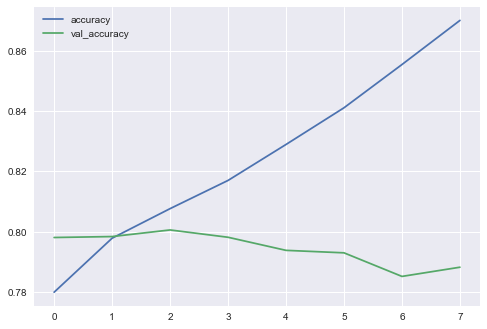

In [37]:
metrics_bert[['accuracy','val_accuracy']].plot()
plt.savefig('../figures/bert_acc.jpg', dpi=300)

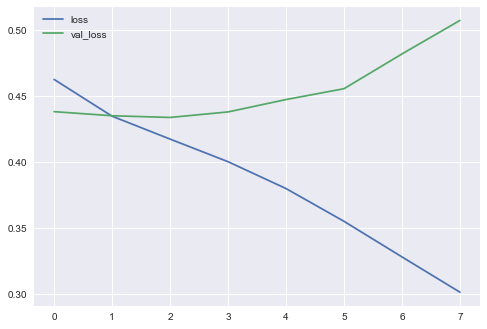

In [38]:
metrics_bert[['loss','val_loss']].plot()
plt.savefig('../figures/bert_loss.jpg', dpi=300)

In [39]:
# Loss metrics for the trained model
test_loss, test_accuracy, test_precision, test_recall = bert_model.evaluate([test_input_ids, test_input_masks, test_segment_ids], test_labels)

32000/32000 [==============================] - 455s 14ms/step


In [40]:
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')
print(f'Test precision: {test_precision}')
print(f'Test recall: {test_recall}')

Test loss: 0.4366583449393511
Test accuracy: 0.7951562404632568
Test precision: 0.786424458026886
Test recall: 0.8064698576927185


In [41]:
bert_model.save('../models/bert_model.h5')